In [1]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
data_frame = pd.read_csv("MSFT_chart.csv")

In [3]:
data_frame

,date,X,open,high,low,close,volume
0,2008-05-05 09:30,5,29.93,30.23,29.900,29.98,5716800
1,2008-05-05 09:35,5,29.98,30.12,29.910,30.11,3360700
2,2008-05-05 09:40,5,30.12,30.12,30.000,30.01,2207200
3,2008-05-05 09:45,5,30.00,30.09,29.950,30.06,2318900
4,2008-05-05 09:50,5,30.05,30.06,29.860,29.90,2785400
...,...,...,...,...,...,...,...
285437,2022-12-07 15:35,7,244.63,244.86,244.400,244.80,146978
285438,2022-12-07 15:40,7,244.80,244.88,244.520,244.60,128576
285439,2022-12-07 15:45,7,244.58,244.85,244.535,244.67,147893
285440,2022-12-07 15:50,7,244.68,244.83,244.510,244.64,208662


In [4]:
Pattern_list = ["Hammer","Belt_Hold_Bearish","Belt_Hold_Bullish","Dragonfly_Doji","Gravestone_Doji","Long-Legged-Doji"]

In [7]:
def change_granularity_to_day(df: pd.DataFrame):
    df['date'] = pd.to_datetime(df['date'])
    data_f = df.groupby(pd.Grouper(key='date', freq='D')).agg(
        {"open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"})
    data_f.columns = ["open", "high", "low", "close", "volume"]
    return data_f.dropna().reset_index()


def change_granularity_to_day_2(df: pd.DataFrame):
    df['date'] = pd.to_datetime(df['date']).dt.date
    data_f = df.groupby("date").agg(
        {"open": "first", "high": ["max"], "low": ["min"], "close": "last", "volume": ["sum"]})
    data_f.columns = ["open", "high", "low", "close", "volume"]
    return data_f.reset_index()
    

def add_pattern_columns(df: pd.DataFrame, epsilon_1, epsilon_2, epsilon_3, epsilon_4, belt_hold_ratio,
                        doji_ratio):
    df["div"] = df["close"] / df["open"]
    df["body_length"] = abs(df["close"] - df["open"])
    df["lower_shadow"] = df[["open", "close"]].min(axis=1) - df["low"]
    df["upper_shadow"] = df["high"] - df[["open", "close"]].max(axis=1)
    df["is_Hammer"] = (2 * df["body_length"] <= df["lower_shadow"]) & (
                    df["lower_shadow"] <= 3 * df["body_length"]) & (
                                      df["body_length"] <= epsilon_1 * df["lower_shadow"]) & (
                                      df["upper_shadow"] == 0)
    df["is_Belt_Hold_Bearish"] = (df["close"] < df["open"]) & (df["open"] == df["high"]) & (
                    abs(df["close"] - df["low"]) <= epsilon_2) & (
                                                 df["body_length"] >= belt_hold_ratio * abs(df["close"] - df["low"]))
    df["is_Belt_Hold_Bullish"] = (df["close"] > df["open"]) & (df["open"] == df["low"]) & (
                    abs(df["high"] - df["close"]) <= epsilon_3) & (df["body_length"] >= belt_hold_ratio * abs(
                df["high"] - df["close"]))
    df["is_Dragonfly_Doji"] = (abs(df["open"] - df["high"]) <= epsilon_4) & (
                    abs(df["close"] - df["high"]) <= epsilon_4) & (df["lower_shadow"] >= doji_ratio * df["body_length"])
    df["is_Gravestone_Doji"] = (abs(df["open"] - df["low"]) <= epsilon_4) & (
                    abs(df["close"] - df["low"]) <= epsilon_4) & (df["upper_shadow"] >= doji_ratio * df["body_length"])
    df["is_Long-Legged-Doji"] = (abs(df["open"] - df["close"]) <= epsilon_4) & (
                    df["lower_shadow"] >= (doji_ratio / 2) * df["body_length"]) & (
                                                    df["upper_shadow"] >= (doji_ratio / 2) * df["body_length"])



def add_trend(df: pd.DataFrame, nb_days):
    df["Moving_Average"] = df["close"].rolling(window=nb_days).mean()
    df.loc[df["close"] > df["Moving_Average"], 'Trend'] = 'Up'
    df.loc[df["close"] < df["Moving_Average"], 'Trend'] = 'Down'
    df.loc[df["close"] == df["Moving_Average"], 'Trend'] = 'Stable'
    return df

def add_trend_2(df: pd.DataFrame, nb_days, threshold):
    df["Moving_Average"] = df["close"].rolling(window=nb_days).mean()
    df.loc[(df["close"] - df["Moving_Average"]) / df["Moving_Average"] > threshold, 'Trend'] = 'Up'
    df.loc[(df["close"] - df["Moving_Average"]) / df["Moving_Average"] < -threshold, 'Trend'] = 'Down'
    df.loc[((df["close"] - df["Moving_Average"]) / df["Moving_Average"] <= threshold)&(-threshold<=(df["close"] - df["Moving_Average"]) / df["Moving_Average"]), 'Trend'] = 'Stable'
    return df
def add_pattern_names_column(df: pd.DataFrame):
    for pattern in Pattern_list:
        df.loc[df[f"is_{pattern}"]==True,"pattern_name"] = pattern
    df["pattern_name"].fillna("Unknown",inplace=True)

data_f = change_granularity_to_day(data_frame)
data_f = add_trend_2(data_f, 10,1e-6)
add_pattern_columns(data_f, 0.6, 0.1, 0.2, 0.2, 10, 20)
add_pattern_names_column(data_f)
df = data_f[0:51]
bl = hammer = (df["Trend"].shift(6) == "Down")&(df["Trend"].shift(-6) == "Up")
hammer = (df["Trend"].shift(6) == "Down")&(df["is_Hammer"]==True)&(df["Trend"].shift(-6) == "Up")
"""hover_text = [f"Date: {date}<br>"
              f"Open: {open_val}<br>"
              f"High: {high_val}<br>"
              f"Low: {low_val}<br>"
              f"Close: {close_val}<br>"
              f"Pattern Name: {pattern_name}" for date, open_val, high_val, low_val, close_val, pattern_name in zip(df['date'], df['open'], df['high'], df['low'], df['close'], df['pattern_name'])]
"""
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'],
                                     hovertext=[f"Pattern Name: {pattern}<br>Pahjkf:" for pattern in df["pattern_name"]])])



# fig.add_trace(go.Line(x=df["date"], y=df["Moving_Average"]))

fig.show()

In [8]:
df[df["is_Hammer"]==True]

,date,open,high,low,close,volume,Moving_Average,Trend,div,body_length,lower_shadow,upper_shadow,is_Hammer,is_Belt_Hold_Bearish,is_Belt_Hold_Bullish,is_Dragonfly_Doji,is_Gravestone_Doji,is_Long-Legged-Doji,pattern_name


In [9]:
bl.sum()

10

In [10]:
hammer.sum()

0

In [11]:
df

,date,open,high,low,close,volume,Moving_Average,Trend,div,body_length,lower_shadow,upper_shadow,is_Hammer,is_Belt_Hold_Bearish,is_Belt_Hold_Bullish,is_Dragonfly_Doji,is_Gravestone_Doji,is_Long-Legged-Doji,pattern_name
0,2008-05-05,29.93,30.23,28.99,29.08,100530100,NaN,NaN,0.971600,0.85,0.09,0.30,False,False,False,False,False,False,Unknown
1,2008-05-06,29.00,29.86,28.93,29.70,83549200,NaN,NaN,1.024138,0.70,0.07,0.16,False,False,False,False,False,False,Unknown
2,2008-05-07,29.69,30.14,29.08,29.21,80692200,NaN,NaN,0.983833,0.48,0.13,0.45,False,False,False,False,False,False,Unknown
3,2008-05-08,29.30,29.39,29.00,29.27,61216900,NaN,NaN,0.998976,0.03,0.27,0.09,False,False,False,False,False,False,Unknown
4,2008-05-09,29.16,29.55,28.95,29.39,30512600,NaN,NaN,1.007888,0.23,0.21,0.16,False,False,False,False,False,False,Unknown
5,2008-05-12,29.40,30.06,29.35,29.99,59188000,NaN,NaN,1.020068,0.59,0.05,0.07,False,False,False,False,False,False,Unknown
6,2008-05-13,30.00,30.13,29.53,29.78,65919400,NaN,NaN,0.992667,0.22,0.25,0.13,False,False,False,False,False,False,Unknown
7,2008-05-14,29.89,30.26,29.73,29.93,60882800,NaN,NaN,1.001338,0.04,0.16,0.33,False,False,False,False,False,False,Unknown
8,2008-05-15,29.98,30.53,29.94,30.45,47085800,NaN,NaN,1.015677,0.47,0.04,0.08,False,False,False,False,False,False,Unknown
9,2008-05-16,30.47,30.48,29.92,29.99,73335000,29.679,Up,0.984247,0.48,0.07,0.01,False,False,False,False,False,False,Unknown


In [12]:
up_trend_after_pattern_count = df[(df.shift(-3)["Trend"] == "Up") & (df[f"is_Hammer"] == True)]

In [13]:
up_trend_after_pattern_count

,date,open,high,low,close,volume,Moving_Average,Trend,div,body_length,lower_shadow,upper_shadow,is_Hammer,is_Belt_Hold_Bearish,is_Belt_Hold_Bullish,is_Dragonfly_Doji,is_Gravestone_Doji,is_Long-Legged-Doji,pattern_name


In [14]:
def change_granularity_to_day(df: pd.DataFrame):
    df['date'] = pd.to_datetime(df['date'])
    data_f = df.groupby(pd.Grouper(key='date', freq='d')).agg(
        {"open": "first", "high": ["max"], "low": ["min"], "close": "last", "volume": ["sum"]})
    data_f.columns = ["open", "high", "low", "close", "volume"]
    return data_f.reset_index()

data_f = change_granularity_to_day(data_frame)
df = data_f[0:51]
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'],
                                     hovertext=
                                     'Date: %{x}<br>' +
                                     'Open: %{open}<br>' +
                                     'High: %{high}<br>' +
                                     'Low: %{low}<br>' +
                                     'Close: %{close}<br>' +
                                     'Bullish Reversal Rate: 2<br>' +
                                     'Breakout: 48 <br>')])

fig.show()



In [15]:

Pattern_list = ["Hammer",
                "Dragon_Fly_Doji",
                "Grave_Stone_Doji",
                "Long_Legged_Doji",
                "Engulfing_Bullish",
                "Closing_Black_Marubozu",
                "Closing_White_Marubozu",
                "Opening_Black_Marubozu",
                "Opening_White_Marubozu",
                "White_Marubozu",
                "Rickshaw_Man",
                "Shooting_Star_One_Candle",
                "Black_Spinning_Top",
                "White_Spinning_Top",
                "Takuri_Line",
                "Bullish_Meeting_Lines",
                "On_Neck",
                "Piercing_Pattern",
                "Bearish_Separating_Lines",
                "Bullish_Separating_Lines",
                "Shooting_Star_Two_Candles",
                "Thrusting",
                "Tweezers_Bottom",
                "Tweezers_Top"]
L = ["pattern_count",
         "up_trend_after_pattern_count",
         "down_trend_after_pattern_count",
         "stable_trend_after_pattern_count",
         "up_after_up",
         "up_after_down",
         "up_after_stable",
         "down_after_up",
         "down_after_down",
         "down_after_stable",
         "stable_after_up",
         "stable_after_down",
         "stable_after_stable",
         "up_and_pattern",
         "down_and_pattern",
         "stable_and_pattern"]
pattern_other_info = {}
for feature in L:
    pattern_other_info[feature] = {}
    for pattern in Pattern_list:
        pattern_other_info[feature][pattern] = 0

In [16]:
pattern_other_info

{'pattern_count': {'Hammer': 0,
  'Dragon_Fly_Doji': 0,
  'Grave_Stone_Doji': 0,
  'Long_Legged_Doji': 0,
  'Engulfing_Bullish': 0,
  'Closing_Black_Marubozu': 0,
  'Closing_White_Marubozu': 0,
  'Opening_Black_Marubozu': 0,
  'Opening_White_Marubozu': 0,
  'White_Marubozu': 0,
  'Rickshaw_Man': 0,
  'Shooting_Star_One_Candle': 0,
  'Black_Spinning_Top': 0,
  'White_Spinning_Top': 0,
  'Takuri_Line': 0,
  'Bullish_Meeting_Lines': 0,
  'On_Neck': 0,
  'Piercing_Pattern': 0,
  'Bearish_Separating_Lines': 0,
  'Bullish_Separating_Lines': 0,
  'Shooting_Star_Two_Candles': 0,
  'Thrusting': 0,
  'Tweezers_Bottom': 0,
  'Tweezers_Top': 0},
 'up_trend_after_pattern_count': {'Hammer': 0,
  'Dragon_Fly_Doji': 0,
  'Grave_Stone_Doji': 0,
  'Long_Legged_Doji': 0,
  'Engulfing_Bullish': 0,
  'Closing_Black_Marubozu': 0,
  'Closing_White_Marubozu': 0,
  'Opening_Black_Marubozu': 0,
  'Opening_White_Marubozu': 0,
  'White_Marubozu': 0,
  'Rickshaw_Man': 0,
  'Shooting_Star_One_Candle': 0,
  'Black_S

In [17]:
data_frame_ff  = pd.DataFrame(pattern_other_info)

In [18]:
data_frame_ff

,pattern_count,up_trend_after_pattern_count,down_trend_after_pattern_count,stable_trend_after_pattern_count,up_after_up,up_after_down,up_after_stable,down_after_up,down_after_down,down_after_stable,stable_after_up,stable_after_down,stable_after_stable,up_and_pattern,down_and_pattern,stable_and_pattern
Hammer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dragon_Fly_Doji,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Grave_Stone_Doji,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Long_Legged_Doji,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Engulfing_Bullish,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Closing_Black_Marubozu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Closing_White_Marubozu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Opening_Black_Marubozu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Opening_White_Marubozu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
White_Marubozu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
data_frame_ff.shift(0)

,pattern_count,up_trend_after_pattern_count,down_trend_after_pattern_count,stable_trend_after_pattern_count,up_after_up,up_after_down,up_after_stable,down_after_up,down_after_down,down_after_stable,stable_after_up,stable_after_down,stable_after_stable,up_and_pattern,down_and_pattern,stable_and_pattern
Hammer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dragon_Fly_Doji,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Grave_Stone_Doji,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Long_Legged_Doji,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Engulfing_Bullish,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Closing_Black_Marubozu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Closing_White_Marubozu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Opening_Black_Marubozu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Opening_White_Marubozu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
White_Marubozu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
data_frame_ff.index

Index(['Hammer', 'Dragon_Fly_Doji', 'Grave_Stone_Doji', 'Long_Legged_Doji',
       'Engulfing_Bullish', 'Closing_Black_Marubozu', 'Closing_White_Marubozu',
       'Opening_Black_Marubozu', 'Opening_White_Marubozu', 'White_Marubozu',
       'Rickshaw_Man', 'Shooting_Star_One_Candle', 'Black_Spinning_Top',
       'White_Spinning_Top', 'Takuri_Line', 'Bullish_Meeting_Lines', 'On_Neck',
       'Piercing_Pattern', 'Bearish_Separating_Lines',
       'Bullish_Separating_Lines', 'Shooting_Star_Two_Candles', 'Thrusting',
       'Tweezers_Bottom', 'Tweezers_Top'],
      dtype='object')

In [21]:
data_frame_ff.to_dict("records")

[{'pattern_count': 0,
  'up_trend_after_pattern_count': 0,
  'down_trend_after_pattern_count': 0,
  'stable_trend_after_pattern_count': 0,
  'up_after_up': 0,
  'up_after_down': 0,
  'up_after_stable': 0,
  'down_after_up': 0,
  'down_after_down': 0,
  'down_after_stable': 0,
  'stable_after_up': 0,
  'stable_after_down': 0,
  'stable_after_stable': 0,
  'up_and_pattern': 0,
  'down_and_pattern': 0,
  'stable_and_pattern': 0},
 {'pattern_count': 0,
  'up_trend_after_pattern_count': 0,
  'down_trend_after_pattern_count': 0,
  'stable_trend_after_pattern_count': 0,
  'up_after_up': 0,
  'up_after_down': 0,
  'up_after_stable': 0,
  'down_after_up': 0,
  'down_after_down': 0,
  'down_after_stable': 0,
  'stable_after_up': 0,
  'stable_after_down': 0,
  'stable_after_stable': 0,
  'up_and_pattern': 0,
  'down_and_pattern': 0,
  'stable_and_pattern': 0},
 {'pattern_count': 0,
  'up_trend_after_pattern_count': 0,
  'down_trend_after_pattern_count': 0,
  'stable_trend_after_pattern_count': 0,

In [22]:
Li = ["pattern_count", "up_trend_after_pattern_count", "down_trend_after_pattern_count",
         "stable_trend_after_pattern_count"]
pattern_list = ["Hammer", "Dragon_Fly_Doji", "Grave_Stone_Doji"]
table_data = []
for i in range(len(Li)):
    table_data.append(dict())
    for pattern in pattern_list:
        table_data[i][pattern] = 0

In [23]:
table_data

[{'Hammer': 0, 'Dragon_Fly_Doji': 0, 'Grave_Stone_Doji': 0},
 {'Hammer': 0, 'Dragon_Fly_Doji': 0, 'Grave_Stone_Doji': 0},
 {'Hammer': 0, 'Dragon_Fly_Doji': 0, 'Grave_Stone_Doji': 0},
 {'Hammer': 0, 'Dragon_Fly_Doji': 0, 'Grave_Stone_Doji': 0}]

In [36]:
import pandas as pd

data = {
    'startdatetime': [
        '2022-09-02T14:11:00-04:00',
        '2022-09-02T13:21:00-04:00',
        '2022-09-02T12:29:00-04:00',
        '2022-09-02T11:24:00-04:00',
        '2022-09-02T09:51:00-04:00'
    ]
}

df['startdatetime'] = pd.to_datetime(df['startdatetime'])
reference_datetime = pd.to_datetime('2022-09-02T14:11:00-04:00')  # Reference datetime (can be any valid datetime)
df['minutes'] = (df['startdatetime'] - reference_datetime).dt.total_seconds() // 60

print(df['minutes'])

TypeError: Timestamp subtraction must have the same timezones or no timezones

In [34]:
df['startdatetime'].dt.total_seconds()

AttributeError: 'DatetimeProperties' object has no attribute 'total_seconds'

In [25]:
import json
import pandas as pd
import zipfile
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

option_zip = "C:/Users/Franck/Downloads/options_file.zip"


def load_i_th_option_data(i):
    with zipfile.ZipFile(option_zip, "r") as dir_path:
        subdirectory = "quotemedia/"
        for index, file_name in enumerate(dir_path.namelist()):
            if index == i:
                if file_name.startswith(subdirectory):
                    file_size = dir_path.getinfo(file_name).file_size
                    if file_size > 3 * 1024:
                        try:
                            with dir_path.open(file_name, "r") as file:
                                data = json.load(file)
                                int_df = pd.DataFrame(data)
                                option_data = pd.DataFrame(int_df.reset_index()["results"][2][0]["interval"])
                                return option_data
                        except:
                            return None


def black_scholes_option_price(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return call_price, put_price


df = load_i_th_option_data(8)
print(df)

df['startdatetime'] = pd.to_datetime(df['startdatetime'])
df = df.sort_values('startdatetime', ascending=True)

s = df['adjustedclose']
k = df['adjustedopen']
R = 0.05
t = (df['startdatetime'] - df['startdatetime'].shift()).dt.total_seconds() / 3600
sigma_df = list(np.log(df["close"]) / np.log(df["close"].shift()))
vect_sigma = np.array(sigma_df)
vect_sigma[0] = 1
Sigma = vect_sigma.mean()

mse = np.mean((black_scholes_option_price(s, k, R, Sigma, t)[0] - df['close']) ** 2)
print("Erreur quadratique moyenne :", mse)
"""plt.plot(df['startdatetime'], df['close'], label='Prix réel')
plt.plot(df['startdatetime'], black_scholes_option_price(s, k, R, Sigma, t)[0], label='Prix prédit')
plt.xlabel('Date')
plt.ylabel("Prix de l'option")
plt.legend()
plt.show()"""

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Franck/Downloads/options_file.zip'

In [ ]:
real_pr = df['close']

In [ ]:
bl_pr = black_scholes_option_price(s, k, R, Sigma, t)[0]

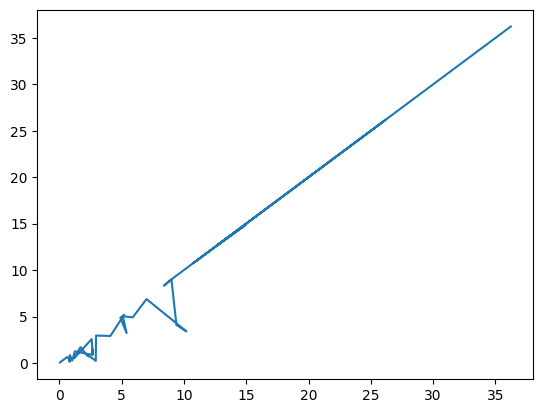

In [ ]:
plt.plot(real_pr,bl_pr)
plt.show()